In [93]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os, math
from tqdm import tqdm_notebook

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


In [164]:
df = pd.read_csv('HPI_master.csv')

In [166]:
usa = df[(df['level'] == 'USA or Census Division') & (df['place_name'] == 'United States') & (df['hpi_flavor'] == 'all-transactions')][['yr','period','index_nsa']]
usa['time'] =usa['yr'].astype(str) + '-' + usa['period'].astype(str)
usa = usa[['time','index_nsa']]
usa['change'] = usa['index_nsa'].shift(-1) / usa['index_nsa']
indice = dict(zip(usa['time'],usa['change']))

In [167]:
df = df[(df['hpi_flavor'] == 'all-transactions') & (df['level'] == 'MSA')]
df['time'] =df['yr'].astype(str) + '-' + df['period'].astype(str)
df = pd.pivot_table(df, values = 'index_nsa', index=['place_name'], columns = 'time').reset_index()

In [168]:
df

time,place_name,1975-1,1975-2,1975-3,1975-4,1976-1,1976-2,1976-3,1976-4,1977-1,...,2017-1,2017-2,2017-3,2017-4,2018-1,2018-2,2018-3,2018-4,2019-1,2019-2
0,"Abilene, TX",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,199.05,210.11,213.20,210.09,211.23,225.27,222.77,228.00,229.03,228.43
1,"Akron, OH",NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.01,41.17,...,144.58,149.08,150.69,152.28,152.30,154.68,161.16,158.05,160.22,165.23
2,"Albany, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,146.45,148.15,151.02,152.56,157.75,153.04,148.83,155.63,153.55,163.30
3,"Albany-Lebanon, OR",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,212.82,218.65,225.32,231.10,236.76,244.53,252.69,259.02,262.90,268.25
4,"Albany-Schenectady-Troy, NY",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,193.94,196.05,199.49,200.20,202.51,202.70,206.08,204.93,206.50,209.04
5,"Albuquerque, NM",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,164.30,166.79,171.19,171.02,172.14,176.41,176.90,176.27,179.10,184.36
6,"Alexandria, LA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,201.37,207.35,213.73,216.93,212.73,215.17,211.19,210.62,215.33,213.29
7,"Allentown-Bethlehem-Easton, PA-NJ",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,171.88,174.52,177.20,178.75,179.70,185.52,187.04,186.76,188.11,192.35
8,"Altoona, PA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,193.55,189.55,198.70,198.80,198.11,206.58,201.50,200.87,194.35,209.48
9,"Amarillo, TX",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,190.44,192.50,193.99,195.53,195.77,198.75,201.19,200.79,200.77,205.32


In [171]:
logReturns = pd.DataFrame(columns=df.columns[2:])
for index, row in df.iterrows():
    nr = []
    vals = row.values
    for i in range(1,len(vals) - 1):
        nr.append(math.log(vals[i + 1] / vals[i] / indice[df.columns[i]]))
    logReturns = logReturns.append(pd.DataFrame([nr], columns=logReturns.columns))

In [197]:
future_prediction = 1 * 4
data_usage = 8 * 4
total_data = data_usage + future_prediction
remove_quarters = future_prediction

vtset = logReturns.columns[0:len(logReturns.columns) - remove_quarters]
training_num = int(len(vtset) * .7)
training_set = logReturns[vtset[0:training_num]]
validation_set = logReturns[vtset[training_num:]]

In [198]:
def batch_generator(dataset, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        while len(x_batch) < batch_size:
            idx = np.random.randint(len(dataset.columns) - total_data)
            series = dataset.sample(n=1)[dataset.columns[idx:idx + total_data]].values[0]
            if np.isnan(series[data_usage: ]).any(): continue
            
            changes = []
            for ret in series[0:data_usage]:
                changes.append([0, 1] if np.isnan(ret) else [ret, 0])
            x_batch.append(np.array(changes).reshape(data_usage,2))
            #y_batch.append((series[data_usage: ] * return_diff + return_min).prod())
            y_batch.append(np.sum(series[data_usage: ]))
        
        yield (np.array(x_batch), np.array(y_batch))
        
batch_size = 128
training_generator = batch_generator(training_set, batch_size)
validation_generator = batch_generator(validation_set, batch_size)

In [199]:
model = Sequential()
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, input_shape=(data_usage,2)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mae', optimizer='adam')

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________


In [210]:
for _ in tqdm_notebook(range(100)):
    model.fit_generator(generator=training_generator,
                        epochs=1,
                        steps_per_epoch=10,
                        validation_steps=5,
                        verbose=1,
                        validation_data=validation_generator)


Epoch 1/1
10/10 [==============================] - 6s 607ms/step - loss: 0.0260 - val_loss: 0.0204
Epoch 1/1
10/10 [==============================] - 5s 549ms/step - loss: 0.0268 - val_loss: 0.0205
Epoch 1/1
10/10 [==============================] - 6s 599ms/step - loss: 0.0289 - val_loss: 0.0198
Epoch 1/1
10/10 [==============================] - 6s 618ms/step - loss: 0.0268 - val_loss: 0.0188
Epoch 1/1
10/10 [==============================] - 6s 603ms/step - loss: 0.0280 - val_loss: 0.0205
Epoch 1/1
10/10 [==============================] - 6s 582ms/step - loss: 0.0274 - val_loss: 0.0193
Epoch 1/1
10/10 [==============================] - 5s 550ms/step - loss: 0.0278 - val_loss: 0.0207
Epoch 1/1
10/10 [==============================] - 6s 572ms/step - loss: 0.0263 - val_loss: 0.0191
Epoch 1/1
10/10 [==============================] - 6s 553ms/step - loss: 0.0279 - val_loss: 0.0194
Epoch 1/1
10/10 [==============================] - 6s 605ms/step - loss: 0.0264 - val_loss: 0.0196
Epoch 1/1


10/10 [==============================] - 6s 593ms/step - loss: 0.0266 - val_loss: 0.0192
Epoch 1/1
10/10 [==============================] - 6s 551ms/step - loss: 0.0260 - val_loss: 0.0206
Epoch 1/1
10/10 [==============================] - 6s 579ms/step - loss: 0.0275 - val_loss: 0.0184
Epoch 1/1
10/10 [==============================] - 6s 583ms/step - loss: 0.0279 - val_loss: 0.0213
Epoch 1/1
10/10 [==============================] - 6s 578ms/step - loss: 0.0267 - val_loss: 0.0184
Epoch 1/1
10/10 [==============================] - 6s 618ms/step - loss: 0.0256 - val_loss: 0.0208
Epoch 1/1
10/10 [==============================] - 6s 629ms/step - loss: 0.0270 - val_loss: 0.0189
Epoch 1/1
10/10 [==============================] - 6s 579ms/step - loss: 0.0268 - val_loss: 0.0191
Epoch 1/1
10/10 [==============================] - 6s 573ms/step - loss: 0.0266 - val_loss: 0.0197
Epoch 1/1
10/10 [==============================] - 6s 586ms/step - loss: 0.0277 - val_loss: 0.0196
Epoch 1/1
10/10 [===

10/10 [==============================] - 6s 590ms/step - loss: 0.0267 - val_loss: 0.0194
Epoch 1/1
10/10 [==============================] - 6s 572ms/step - loss: 0.0259 - val_loss: 0.0201
Epoch 1/1
10/10 [==============================] - 6s 559ms/step - loss: 0.0277 - val_loss: 0.0197
Epoch 1/1
10/10 [==============================] - 6s 581ms/step - loss: 0.0258 - val_loss: 0.0199
Epoch 1/1
10/10 [==============================] - 7s 654ms/step - loss: 0.0260 - val_loss: 0.0204
Epoch 1/1
10/10 [==============================] - 6s 613ms/step - loss: 0.0265 - val_loss: 0.0197
Epoch 1/1
10/10 [==============================] - 6s 550ms/step - loss: 0.0266 - val_loss: 0.0188
Epoch 1/1
10/10 [==============================] - 6s 577ms/step - loss: 0.0262 - val_loss: 0.0207
Epoch 1/1
10/10 [==============================] - 6s 557ms/step - loss: 0.0263 - val_loss: 0.0196
Epoch 1/1
10/10 [==============================] - 6s 569ms/step - loss: 0.0251 - val_loss: 0.0199
Epoch 1/1
10/10 [===

10/10 [==============================] - 6s 603ms/step - loss: 0.0269 - val_loss: 0.0188
Epoch 1/1
10/10 [==============================] - 6s 606ms/step - loss: 0.0257 - val_loss: 0.0185
Epoch 1/1
10/10 [==============================] - 5s 525ms/step - loss: 0.0268 - val_loss: 0.0196
Epoch 1/1
10/10 [==============================] - 6s 594ms/step - loss: 0.0270 - val_loss: 0.0185
Epoch 1/1
10/10 [==============================] - 6s 584ms/step - loss: 0.0259 - val_loss: 0.0198
Epoch 1/1
10/10 [==============================] - 6s 586ms/step - loss: 0.0273 - val_loss: 0.0201
Epoch 1/1
10/10 [==============================] - 6s 580ms/step - loss: 0.0269 - val_loss: 0.0191
Epoch 1/1
10/10 [==============================] - 6s 568ms/step - loss: 0.0264 - val_loss: 0.0186
Epoch 1/1
10/10 [==============================] - 5s 546ms/step - loss: 0.0266 - val_loss: 0.0201
Epoch 1/1
10/10 [==============================] - 6s 614ms/step - loss: 0.0262 - val_loss: 0.0186
Epoch 1/1
10/10 [===

10/10 [==============================] - 6s 625ms/step - loss: 0.0269 - val_loss: 0.0195
Epoch 1/1
10/10 [==============================] - 6s 569ms/step - loss: 0.0257 - val_loss: 0.0190
Epoch 1/1
10/10 [==============================] - 6s 569ms/step - loss: 0.0282 - val_loss: 0.0193
Epoch 1/1
10/10 [==============================] - 6s 551ms/step - loss: 0.0259 - val_loss: 0.0198
Epoch 1/1
10/10 [==============================] - 6s 564ms/step - loss: 0.0257 - val_loss: 0.0193
Epoch 1/1
10/10 [==============================] - 6s 568ms/step - loss: 0.0256 - val_loss: 0.0196
Epoch 1/1
10/10 [==============================] - 5s 549ms/step - loss: 0.0272 - val_loss: 0.0187
Epoch 1/1
10/10 [==============================] - 6s 615ms/step - loss: 0.0280 - val_loss: 0.0203
Epoch 1/1
10/10 [==============================] - 6s 611ms/step - loss: 0.0261 - val_loss: 0.0205
Epoch 1/1
10/10 [==============================] - 6s 566ms/step - loss: 0.0283 - val_loss: 0.0196
Epoch 1/1
10/10 [===

10/10 [==============================] - 6s 582ms/step - loss: 0.0273 - val_loss: 0.0197
Epoch 1/1
10/10 [==============================] - 6s 559ms/step - loss: 0.0269 - val_loss: 0.0198
Epoch 1/1
10/10 [==============================] - 6s 584ms/step - loss: 0.0272 - val_loss: 0.0191
Epoch 1/1
10/10 [==============================] - 6s 584ms/step - loss: 0.0275 - val_loss: 0.0195
Epoch 1/1
10/10 [==============================] - 6s 644ms/step - loss: 0.0289 - val_loss: 0.0195
Epoch 1/1
 9/10 [==========================>...] - ETA: 0s - loss: 0.0262

KeyboardInterrupt: 

In [211]:
n = len(logReturns.columns)
x_raw = logReturns[logReturns.columns[n - total_data: n - future_prediction]].as_matrix()
x_test = []
for example in x_raw: 
    nans = np.isnan(example)
    example[nans] = 0
    x_test.append(np.array(np.column_stack((example,nans))))
x_test = np.array(x_test)

In [212]:
predict = math.e ** model.predict(x_test)[:,0]
real = math.e ** logReturns[logReturns.columns[-future_prediction:]].as_matrix().sum(axis=1)

In [213]:
zipped = np.array(list(zip(real,predict)))
zipped = zipped[~np.isnan(zipped).any(axis=1)]
predict = zipped[:,1]
real = zipped[:,0]

r2 0.16631433989156436


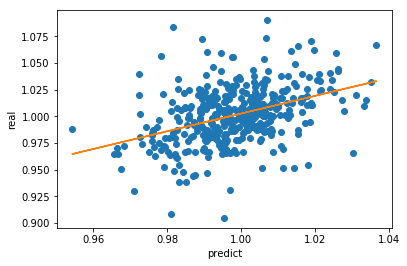

In [214]:
from scipy import stats
bslope, bintercept, br_value, bp_value, bstd_err = stats.linregress(predict,real)

slope, intercept, r_value, p_value, std_err = stats.linregress(predict,real)
print('r2',r_value ** 2)

line = slope*predict+intercept
plt.plot(predict,real,'o', predict, line)
plt.xlabel('predict')
plt.ylabel('real')
#plt.scatter(predict, real)
plt.show()